In [ ]:
import firebase_admin
from firebase_admin import credentials, storage, firestore
import json
import os
from google.colab import userdata
key_json = userdata.get('firebase') #colab 환경

try:
    with open('firebase_key.json', 'w') as f:
        json.dump(json.loads(key_json), f)
    key_path = 'firebase_key.json'
except json.JSONDecodeError:
    # If the key is not valid JSON, assume it's already a file path
    key_path = key_json

cred = credentials.Certificate(key_path)
if not firebase_admin._apps:
    firebase_admin.initialize_app(cred, {
        'storageBucket': 'fairplayfairy-3e2eb.firebasestorage.app'
    })
    print("Firebase 앱이 성공적으로 초기화되었습니다.")
else:
    print("Firebase 앱이 이미 초기화되어 있습니다.")

# Storage 버킷 객체 가져오기 예시
bucket = storage.bucket()
print("Storage 버킷에 접근 성공:", bucket.name)
# Database 객체 가져오기 예시
database = firestore.client()
print("Database에 접근 성공:", database)

Firebase 앱이 이미 초기화되어 있습니다.
Storage 버킷에 접근 성공: fairplayfairy-3e2eb.firebasestorage.app
Database에 접근 성공: <google.cloud.firestore_v1.client.Client object at 0x7bfa40700b00>


In [ ]:
import cv2
import numpy as np
import tempfile
import os
from google.colab.patches import cv2_imshow # cv2.imshow 대체용
from firebase_admin import firestore # Jupyter Notebook 첫 번째 셀에서 'from firebase_admin import firestore'가 실행되어야 합니다.

def analyze_full_accuracy(video_blob):
    """
    영상 분석을 위한 최종 통합 함수.
    Firestore에서 메타데이터를 가져오고, Storage에서 영상을 다운로드하여
    킬, 헤드샷, 일반 명중, 발사 횟수를 분석하고 최종 명중률을 계산합니다.
    """

    #  Storage 영상을 임시 파일로 다운로드
    fd, temp_path = tempfile.mkstemp(suffix=".webm")
    os.close(fd)

    # Firestore에서 메타데이터 가져오기
    try:
        firestore_client = firestore.client()
        doc_id = video_blob.name.replace('videos/', '').replace('.webm', '')
        doc_ref = firestore_client.collection('game_results').document(doc_id)
        metadata_snapshot = doc_ref.get()
        if metadata_snapshot.exists:
            metadata = metadata_snapshot.to_dict()
            print("Firestore 메타데이터 가져오기 성공:", doc_id, metadata)
        else:
            print(f"Firestore에서 문서를 찾을 수 없습니다: game_results/{doc_id}")
            return
    except Exception as e:
        print(f"Firestore에서 데이터를 가져오는 중 오류 발생: {e}")
        return

    fd, temp_path = tempfile.mkstemp(suffix=".webm")
    os.close(fd)

    try:
        print(f"영상을 임시 파일로 다운로드 중... -> {temp_path}")
        video_blob.download_to_filename(temp_path)
        print("다운로드 완료.")

        cap = cv2.VideoCapture(temp_path)
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
        if fps > 120:
            print(f"[경고] 비정상적으로 높은 FPS({fps}) 감지됨. 30.0으로 고정합니다.")
            fps = 30.0
        print(f"영상 정보 - 해상도: {width}x{height}, FPS: {fps}")
        # === 디버그 영상 저장 설정 ===
        SAVE_DEBUG_VIDEO = True
        debug_dir = os.path.join(os.getcwd(), "debug_videos")
        os.makedirs(debug_dir, exist_ok=True)
        # Firestore 문서 id를 파일명으로 사용
        debug_out_path = os.path.join(debug_dir, f"{doc_id}_roi_debug.mp4")
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out_fps = 30.0 # FPS 고정
        writer = cv2.VideoWriter(debug_out_path, fourcc, out_fps, (width, height))
        print(f"ROI 디버그 영상 저장 경로: {debug_out_path}")

        # --- ROI: 크로스헤어 중심, 총구는 오른쪽-아래 오프셋 + 더 크게 ---
        crosshair_size = max(24, int(min(height, width) * 0.05))
        ch_center_x = int(width/2)
        ch_center_y = int(height/2)
        ch_x = ch_center_x - crosshair_size // 2
        ch_y = ch_center_y - crosshair_size // 2


        # 총구 화염 ROI 크기(크로스헤어보다 큼)
        muzzle_h = muzzle_w = max(120, int(min(height, width) * 0.14))
        # 오른쪽-아래 오프셋(해상도 비례) → 필요 시 수치 미세조정
        offset_y = int(height * 0.03)   # 아래쪽
        offset_x = int(width  * 0.04)   # 오른쪽
        mz_cy = int(height/2) + offset_y
        mz_cx = int(width/2)  + offset_x
        mz_y = max(0, mz_cy - muzzle_h // 2)
        mz_x = max(0, mz_cx - muzzle_w // 2)

        # --- 색상 범위 ---
        lower_red1, upper_red1 = np.array([0, 150, 120]),  np.array([10, 255, 255])#킬 크로스헤어 빨강
        lower_red2, upper_red2 = np.array([170, 150, 120]), np.array([180, 255, 255])#킬 크로스헤어 빨강
        lower_orange, upper_orange = np.array([10, 150, 120]), np.array([35, 255, 255])#헤드샷 크로스헤어 주황
        lower_white, upper_white = np.array([0, 0, 200]),   np.array([255, 40, 255])#일반 명중 크로스헤어 흰색
        lower_yellow, upper_yellow = np.array([15, 120, 180]), np.array([35, 255, 255])#발사 화염 노랑~주황

        # --- 상태/시간 파라미터(밀리초 기반) ---
        COOLDOWN_MS     = 120
        HIT_IGNORE_MS   = 90    # 발사 직후 잠깐 대기(총구 화염 간섭 회피)
        HIT_WINDOW_MS   = 240   # 이 안에서만 명중 판정
        COOLDOWN_FRAMES   = max(1, int(COOLDOWN_MS   * fps / 1000))
        HIT_IGNORE_FRAMES = max(1, int(HIT_IGNORE_MS * fps / 1000))
        HIT_SCAN_WINDOW   = max(HIT_IGNORE_FRAMES + 1, int(HIT_WINDOW_MS * fps / 1000))

        # 비율 임계값(ROI 대비 마스크 픽셀 비율)
        SHOT_RATIO_TH = 0.3   # 총구 노랑 비율 0.8%↑ → 발사
        HIT_RATIO_TH  = 0.15   # 크로스헤어 색 비율 0.8%↑ → 명중류

        headshot_count = hit_count = kill_count = shots_fired_count = 0
        shot_cooldown = 0
        hit_scan_state = {"active": False, "frames_left": 0}

        kernel = np.ones((3,3), np.uint8)

        # --- 디버그 플래그 ---
        SHOW_DEBUG = False  # 창으로도 보고 싶으면 True
        DRAW_OVERLAY = True if (SHOW_DEBUG or SAVE_DEBUG_VIDEO) else False
        last_muzzle_ratio = 0.0
        last_red_ratio = last_orange_ratio = last_white_ratio = 0.0

        print("종합 분석을 시작합니다 (오프셋/타이밍 보정)...")

        # --- 사다리꼴 마스크 꼭짓점 계산 (크로스헤어 중심 기준) ---
        # (-1,-1)~(1,1) 정사각형 기준 좌표: (0.6, 0.75), (0.7, 0.75), (0.9, 1), (1, 1)
        # 픽셀 좌표로 변환: (중심_x + x' * size, 중심_y + y' * size)
        # 여기서 size는 crosshair_size에 해당하며, 이는 중심에서 1.0으로 스케일링된 거리를 의미합니다.
        scaled_size = crosshair_size

        # 원본 사다리꼴
        trap_pts_orig = np.array([
            [ch_center_x + int(0.2 * scaled_size), ch_center_y + int(0.3 * scaled_size)],
            [ch_center_x + int(0.3 * scaled_size), ch_center_y + int(0.4 * scaled_size)],
            [ch_center_x + int(0.4 * scaled_size), ch_center_y + int(0.5 * scaled_size)],
            [ch_center_x + int(0.5 * scaled_size), ch_center_y + int(0.6 * scaled_size)]
        ], np.int32)

        # X축 대칭 사다리꼴
        trap_pts_x_sym = np.array([
            [ch_center_x + int(0.2 * scaled_size), ch_center_y + int(-0.3 * scaled_size)],
            [ch_center_x + int(0.3 * scaled_size), ch_center_y + int(-0.4 * scaled_size)],
            [ch_center_x + int(0.4 * scaled_size), ch_center_y + int(-0.5 * scaled_size)],
            [ch_center_x + int(0.5 * scaled_size), ch_center_y + int(-0.6 * scaled_size)]
        ], np.int32)

        # Y축 대칭 사다리꼴
        trap_pts_y_sym = np.array([
            [ch_center_x + int(-0.2 * scaled_size), ch_center_y + int(0.3 * scaled_size)],
            [ch_center_x + int(-0.3 * scaled_size), ch_center_y + int(0.4 * scaled_size)],
            [ch_center_x + int(-0.4 * scaled_size), ch_center_y + int(0.5 * scaled_size)],
            [ch_center_x + int(-0.5 * scaled_size), ch_center_y + int(0.6 * scaled_size)]
        ], np.int32)

        # 원점 대칭 사다리꼴
        trap_pts_origin_sym = np.array([
            [ch_center_x + int(-0.2 * scaled_size), ch_center_y + int(-0.3 * scaled_size)],
            [ch_center_x + int(-0.3 * scaled_size), ch_center_y + int(-0.4 * scaled_size)],
            [ch_center_x + int(-0.4 * scaled_size), ch_center_y + int(-0.5 * scaled_size)],
            [ch_center_x + int(-0.5 * scaled_size), ch_center_y + int(-0.6 * scaled_size)]
        ], np.int32)

        # 다각형을 그릴 때는 reshape(-1, 1, 2) 형태가 필요
        trap_pts_orig = trap_pts_orig.reshape((-1, 1, 2))
        trap_pts_x_sym = trap_pts_x_sym.reshape((-1, 1, 2))
        trap_pts_y_sym = trap_pts_y_sym.reshape((-1, 1, 2))
        trap_pts_origin_sym = trap_pts_origin_sym.reshape((-1, 1, 2))


        while True:
            ret, frame = cap.read()
            if not ret: break

            if shot_cooldown > 0: shot_cooldown -= 1
            if hit_scan_state["active"]: hit_scan_state["frames_left"] -= 1

            # --- (1) 발사 감지 ---
            shot_fired_this_frame = False
            if shot_cooldown == 0:
                muzzle_roi = frame[mz_y:min(height, mz_y + muzzle_h), mz_x:min(width, mz_x + muzzle_w)]
                if muzzle_roi.size > 0:
                    hsv_muzzle = cv2.cvtColor(muzzle_roi, cv2.COLOR_BGR2HSV)
                    yellow_mask = cv2.inRange(hsv_muzzle, lower_yellow, upper_yellow)
                    yellow_mask = cv2.dilate(yellow_mask, kernel, iterations=1)
                    muzzle_ratio = cv2.countNonZero(yellow_mask) / yellow_mask.size
                    last_muzzle_ratio = muzzle_ratio

                    if muzzle_ratio >= SHOT_RATIO_TH:
                        shots_fired_count += 1
                        shot_cooldown = COOLDOWN_FRAMES
                        hit_scan_state = {"active": True, "frames_left": HIT_SCAN_WINDOW}
                        shot_fired_this_frame = True

            # --- (2) 명중 감지 ---
            hit_this_frame = headshot_this_frame = kill_this_frame = False
            if hit_scan_state["active"] and hit_scan_state["frames_left"] < (HIT_SCAN_WINDOW - HIT_IGNORE_FRAMES):
                # 크로스헤어 ROI 대신 전체 프레임에서 마스크를 적용하여 분석
                hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

                # 사다리꼴 마스크 생성 (네 개를 합침)
                roi_mask = np.zeros((height, width), dtype=np.uint8)
                cv2.fillPoly(roi_mask, [trap_pts_orig], 255)
                cv2.fillPoly(roi_mask, [trap_pts_x_sym], 255)
                cv2.fillPoly(roi_mask, [trap_pts_y_sym], 255)
                cv2.fillPoly(roi_mask, [trap_pts_origin_sym], 255)


                # 원본 HSV 이미지에서 색상 감지 마스크 생성
                red_mask_full = cv2.inRange(hsv_frame, lower_red1, upper_red1) + \
                                cv2.inRange(hsv_frame, lower_red2, upper_red2)
                orange_mask_full = cv2.inRange(hsv_frame, lower_orange, upper_orange)
                white_mask_full  = cv2.inRange(hsv_frame, lower_white, upper_white)

                red_mask_full = cv2.dilate(red_mask_full, kernel, iterations=1)
                orange_mask_full = cv2.dilate(orange_mask_full, kernel, iterations=1)
                white_mask_full = cv2.dilate(white_mask_full, kernel, iterations=1)
                # ROI 마스크를 최종 색상 감지 마스크에 적용
                red_mask = cv2.bitwise_and(red_mask_full, red_mask_full, mask=roi_mask)
                orange_mask = cv2.bitwise_and(orange_mask_full, orange_mask_full, mask=roi_mask)
                white_mask = cv2.bitwise_and(white_mask_full, white_mask_full, mask=roi_mask)


                # 마스크 영역의 총 픽셀 수를 계산하여 비율 계산에 사용
                total_mask_pixels = cv2.countNonZero(roi_mask)
                if total_mask_pixels > 0:
                    red_ratio    = cv2.countNonZero(red_mask)    / total_mask_pixels
                    orange_ratio = cv2.countNonZero(orange_mask) / total_mask_pixels
                    white_ratio  = cv2.countNonZero(white_mask)  / total_mask_pixels
                else:
                    red_ratio = orange_ratio = white_ratio = 0.0


                last_red_ratio, last_orange_ratio, last_white_ratio = red_ratio, orange_ratio, white_ratio

                if red_ratio >= HIT_RATIO_TH:
                    kill_count += 1
                    hit_scan_state["active"] = False
                    kill_this_frame = True
                elif orange_ratio >= HIT_RATIO_TH:
                    headshot_count += 1
                    hit_scan_state["active"] = False
                    headshot_this_frame = True
                elif white_ratio >= HIT_RATIO_TH:
                    hit_count += 1
                    hit_scan_state["active"] = False
                    hit_this_frame = True

            # --- (3) 윈도우 종료 ---
            if hit_scan_state["frames_left"] <= 0:
                hit_scan_state["active"] = False

            # --- (4) 오버레이 그리기(저장/표시 공통) ---
            if DRAW_OVERLAY:
                # ROI 박스
                cv2.rectangle(frame, (mz_x, mz_y),
                              (min(width-1, mz_x + muzzle_w), min(height-1, mz_y + muzzle_h)),
                              (0, 255, 255), 2)  # 총구: 노랑

                # 텍스트(비율)
                cv2.putText(frame, f"muzzle_yellow={last_muzzle_ratio:.3f}",
                            (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,255), 2, cv2.LINE_AA)
                cv2.putText(frame, f"red={last_red_ratio:.3f} org={last_orange_ratio:.3f} wht={last_white_ratio:.3f}",
                            (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,200,255), 2, cv2.LINE_AA)
                # 카운트 오버레이 항상 표시
                cv2.putText(frame, f"SHOT: {shots_fired_count}", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,0,255), 3, cv2.LINE_AA)
                cv2.putText(frame, f"HIT: {hit_count}", (10, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 3, cv2.LINE_AA)
                cv2.putText(frame, f"HEAD: {headshot_count}", (10, 210), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,165,255), 3, cv2.LINE_AA)
                cv2.putText(frame, f"KILL: {kill_count}", (10, 260), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,0,0), 3, cv2.LINE_AA)

            # --- (5) 파일로 저장 ---
            if SAVE_DEBUG_VIDEO and writer is not None:
                writer.write(frame)

            # --- (6) 화면 디버그 표시(선택) ---
            if SHOW_DEBUG:
                cv2_imshow(frame) # cv2.imshow 대신 cv2_imshow 사용
                if 'hsv_muzzle' in locals():
                    cv2_imshow(yellow_mask) # cv2.imshow 대신 cv2_imshow 사용
                    print(f"yellow_mask shape: {yellow_mask.shape}") # Debug print for yellow_mask size

                # 마스크가 적용된 HSV 이미지 디버그 표시 (선택 사항)
                #cv2_imshow(hsv_masked) # hsv_masked 변수는 더 이상 사용되지 않습니다.
                # 각 색상 마스크 디버그 표시 (선택 사항)
                # if 'red_mask' in locals():
                #     cv2_imshow(red_mask)
                #     cv2_imshow(orange_mask)
                #     cv2_imshow(white_mask)
                # 최종 마스크 디버그 표시 (선택 사항)
                # Check if roi_mask exists before displaying
                if 'roi_mask' in locals():
                    cv2_imshow(roi_mask)
                    print(f"roi_mask shape: {roi_mask.shape}") # Debug print for roi_mask size


                # cv2.waitKey는 cv2_imshow와 함께 사용할 수 없으므로 주석 처리하거나 제거합니다.
                # if cv2.waitKey(1) & 0xFF == ord('q'):
                #     break

        if SAVE_DEBUG_VIDEO and writer is not None:
            writer.release()
            print(f"디버그 영상 저장 완료: {debug_out_path}")

        cap.release()
        total_hits = kill_count + headshot_count + hit_count
        print("\n\n--- 최종 분석 결과 ---")
        print(f"총 발사 수: {shots_fired_count}발")
        print(f"총 명중 수: {total_hits}회")
        print(f"  - 킬: {kill_count}회")
        print(f"  - 헤드샷 (킬 제외): {headshot_count}회")
        print(f"  - 일반 명중 (킬, 헤드샷 제외): {hit_count}회")

        if shots_fired_count > 0:
            accuracy = (total_hits / shots_fired_count) * 100
            print(f"\n🎯 최종 명중률: {accuracy:.2f}%")
        else:
            print("\n🎯 발사 기록이 없어 명중률을 계산할 수 없습니다.")
    finally:
        print(f"임시 파일 삭제: {temp_path}")
        try:
            cap.release()
        except:
            pass
        try:
            # cv2.destroyAllWindows()는 cv2_imshow와 함께 작동하지 않습니다.
            # cv2 창이 열려 있었다면 수동으로 닫아야 할 수 있습니다.
            pass
        except:
            pass
        try:
            writer.release()
        except:
            pass
        if os.path.exists(temp_path):
            os.remove(temp_path)

In [ ]:
import random
import os

if __name__ == "__main__":
    videos = list(bucket.list_blobs(prefix='videos/09f93'))
    # 샘플 영상 1개 선택 (또는 필요한 영상 선택)
    if videos:
        video_blob = random.choice(videos)
        # Colab 파일 저장소에 저장할 경로 지정 (analyze_full_accuracy 함수 내에서 임시 파일 사용하므로 여기서는 필요 없음)
        save_directory = "/content/downloaded_videos"
        os.makedirs(save_directory, exist_ok=True) # 디렉토리가 없으면 생성

        print(f"분석할 영상: {video_blob.name}")
        # print(f"저장될 로컬 경로: {local_save_path}") # 이제 이 경로는 함수 내부 임시 파일이므로 출력 불필요

        # analyze_full_accuracy 함수 호출 시 video_blob 만 전달
        analyze_full_accuracy(video_blob)
    else:
        print("Firebase Storage의 'videos/' 경로에 영상 파일이 없습니다.")

분석할 영상: videos/09f9344a-ec62-4035-94d8-872fcd4cb45c.webm
Firestore 메타데이터 가져오기 성공: 09f9344a-ec62-4035-94d8-872fcd4cb45c {'totalHeadshots': 22, 'peekingHits': 33, 'finalScore': 26, 'accuracy': 34.19, 'movingHits': 20, 'totalHits': 53, 'totalShots': 155}
영상을 임시 파일로 다운로드 중... -> /tmp/tmpuie2o8ph.webm
다운로드 완료.
영상 정보 - 해상도: 1280x720, FPS: 29.97002997002997
ROI 디버그 영상 저장 경로: /content/debug_videos/09f9344a-ec62-4035-94d8-872fcd4cb45c_roi_debug.mp4
종합 분석을 시작합니다 (오프셋/타이밍 보정)...
디버그 영상 저장 완료: /content/debug_videos/09f9344a-ec62-4035-94d8-872fcd4cb45c_roi_debug.mp4


--- 최종 분석 결과 ---
총 발사 수: 82발
총 명중 수: 25회
  - 킬: 1회
  - 헤드샷 (킬 제외): 14회
  - 일반 명중 (킬, 헤드샷 제외): 10회

🎯 최종 명중률: 30.49%
임시 파일 삭제: /tmp/tmpuie2o8ph.webm


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to analyze colors in a given image (can specify an ROI if needed)
def analyze_colors(image, color_name, roi=None):
    """Analyzes HSV color distribution in an image or a specified ROI."""
    if image is None:
        print(f"Error: Image for {color_name} is not loaded.")
        return

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    if roi:
        # Extract ROI and convert to HSV
        x, y, w, h = roi
        hsv_roi = hsv_image[y:y+h, x:x+w]
        pixels = hsv_roi.reshape(-1, 3)
    else:
        # Use all pixels if no ROI is specified
        pixels = hsv_image.reshape(-1, 3)

    if pixels.size == 0:
        print(f"Warning: No pixels found in the specified ROI for {color_name}.")
        return

    print(f"\nAnalyzing HSV values for {color_name}...")

    # Calculate min/max HSV values
    min_hsv = np.min(pixels, axis=0)
    max_hsv = np.max(pixels, axis=0)

    print(f"  Min HSV: {min_hsv}")
    print(f"  Max HSV: {max_hsv}")

    # Optional: Visualize HSV distribution (Histograms)
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 3, 1)
    # plt.hist(pixels[:, 0], bins=180, range=[0, 180], color='red')
    # plt.title('Hue')
    # plt.subplot(1, 3, 2)
    # plt.hist(pixels[:, 1], bins=256, range=[0, 256], color='green')
    # plt.title('Saturation')
    # plt.subplot(1, 3, 3)
    # plt.hist(pixels[:, 2], bins=256, range=[0, 256], color='blue')
    # plt.title('Value')
    # plt.suptitle(f'HSV Distribution for {color_name}')
    # plt.show()

    return min_hsv, max_hsv

# --- Start: Image Loading (Combined into this cell) ---
# List of image file paths
image_paths = [
    "/content/whiteeffect.png", # White hit effect
    "/content/redeffect.png", # Red kill effect
    "/content/orangeeffect.png"  # Orange headshot effect
]

images = {}
for path in image_paths:
    img = cv2.imread(path)
    if img is not None:
        images[path] = img
        print(f"'{path}' 이미지 로드 성공.")
    else:
        print(f"오류: '{path}' 이미지를 로드할 수 없습니다. 파일 경로를 확인하세요.")

if not images:
    print("오류: 분석할 이미지가 로드되지 않았습니다. 파일 경로를 확인하세요.")
else:
    print(f"총 {len(images)}개의 이미지가 로드되었습니다. 이제 색상 분석을 시작합니다.")
# --- End: Image Loading ---


# Analyze each image
white_hit_img = images.get("/content/whiteeffect.png")
red_kill_img = images.get("/content/redeffect.png")
orange_headshot_img = images.get("/content/orangeeffect.png")

# You might need to adjust the ROI (x, y, w, h) based on where the effect is in your images
# For simplicity, we'll analyze the entire image for now.
# If the effect is small or in a specific location, define an ROI like:
# white_roi = (x, y, width, height) # Example: (100, 100, 50, 50)

white_hsv_range = analyze_colors(white_hit_img, "White Hit Effect")
red_hsv_range = analyze_colors(red_kill_img, "Red Kill Effect")
orange_hsv_range = analyze_colors(orange_headshot_img, "Orange Headshot Effect")

print("\nColor analysis complete. Review the Min/Max HSV values above to determine your cv2.inRange bounds.")

# Optional: Print the suggested ranges for easy copying
print("\nSuggested HSV ranges for cv2.inRange:")
if white_hsv_range:
    print(f"White Hit: Lower={white_hsv_range[0]}, Upper={white_hsv_range[1]}")
if red_hsv_range:
    # Red typically has hue values near 0 and 180. Analyze_colors only gives one range.
    # You might need to define two ranges in your actual code if the hue spans across the 0/180 boundary.
    print(f"Red Kill: Lower={red_hsv_range[0]}, Upper={red_hsv_range[1]}")
if orange_hsv_range:
    print(f"Orange Headshot: Lower={orange_hsv_range[0]}, Upper={orange_hsv_range[1]}")

'/content/whiteeffect.png' 이미지 로드 성공.
'/content/redeffect.png' 이미지 로드 성공.
'/content/orangeeffect.png' 이미지 로드 성공.
총 3개의 이미지가 로드되었습니다. 이제 색상 분석을 시작합니다.

Analyzing HSV values for White Hit Effect...
  Min HSV: [98 15 87]
  Max HSV: [112  63 255]

Analyzing HSV values for Red Kill Effect...
  Min HSV: [ 0 77 50]
  Max HSV: [179 236 200]

Analyzing HSV values for Orange Headshot Effect...
  Min HSV: [ 15 199 142]
  Max HSV: [ 19 255 244]

Color analysis complete. Review the Min/Max HSV values above to determine your cv2.inRange bounds.

Suggested HSV ranges for cv2.inRange:
White Hit: Lower=[98 15 87], Upper=[112  63 255]
Red Kill: Lower=[ 0 77 50], Upper=[179 236 200]
Orange Headshot: Lower=[ 15 199 142], Upper=[ 19 255 244]


In [ ]:
import cv2
import os

# 동영상 파일 열기
video_path = "/content/debug_videos/09f9344a-ec62-4035-94d8-872fcd4cb45c_roi_debug.mp4"
video_name = os.path.basename(video_path)
print(f"동영상 파일: {video_name}")
cap = cv2.VideoCapture(video_path)

frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break  # 영상 끝

    # 프레임별 분석 코드 (예: 프레임 번호 출력)
    print(f"Frame {frame_count} size: {frame.shape}")
    mkdir_path = "/content/frames"
    # 프레임 저장 (원하면)
    os.makedirs(mkdir_path, exist_ok=True)
    cv2.imwrite(f"/content/frames/frame_{frame_count:04d}.jpg", frame)

    frame_count += 1

cap.release()
print("Done.")

In [ ]:
from google.colab import files
import os

# 다운로드할 폴더 경로 설정
folder_path = '/content/frames' # 예시 경로

# 폴더 이름 가져오기
folder_name = os.path.basename(folder_path)

# 폴더 압축
!zip -r /content/{folder_name}.zip {folder_path}


# TODO: 위의 코드를 실행하여 폴더를 압축하고 다운로드하세요.
# Colab 환경에서 직접 실행해야 합니다.

Loaded frame from: /content/frames/frame_0380.jpg
Original Frame:


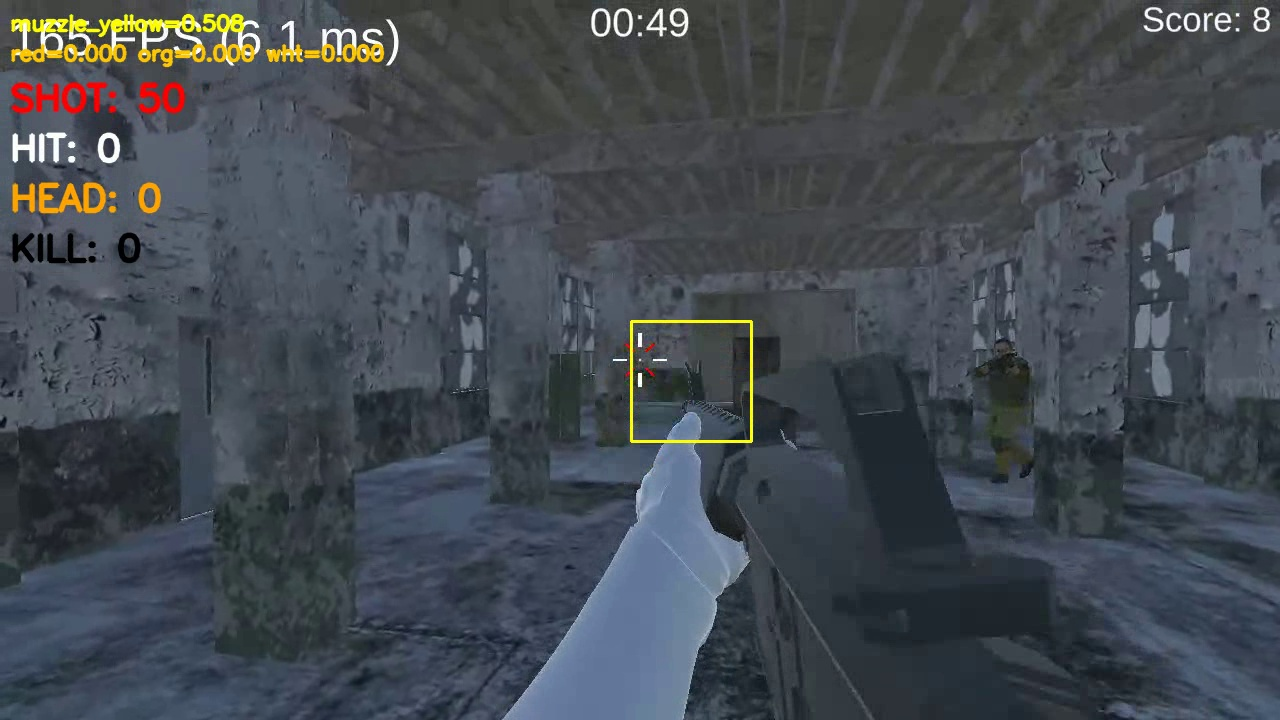

Red Mask:


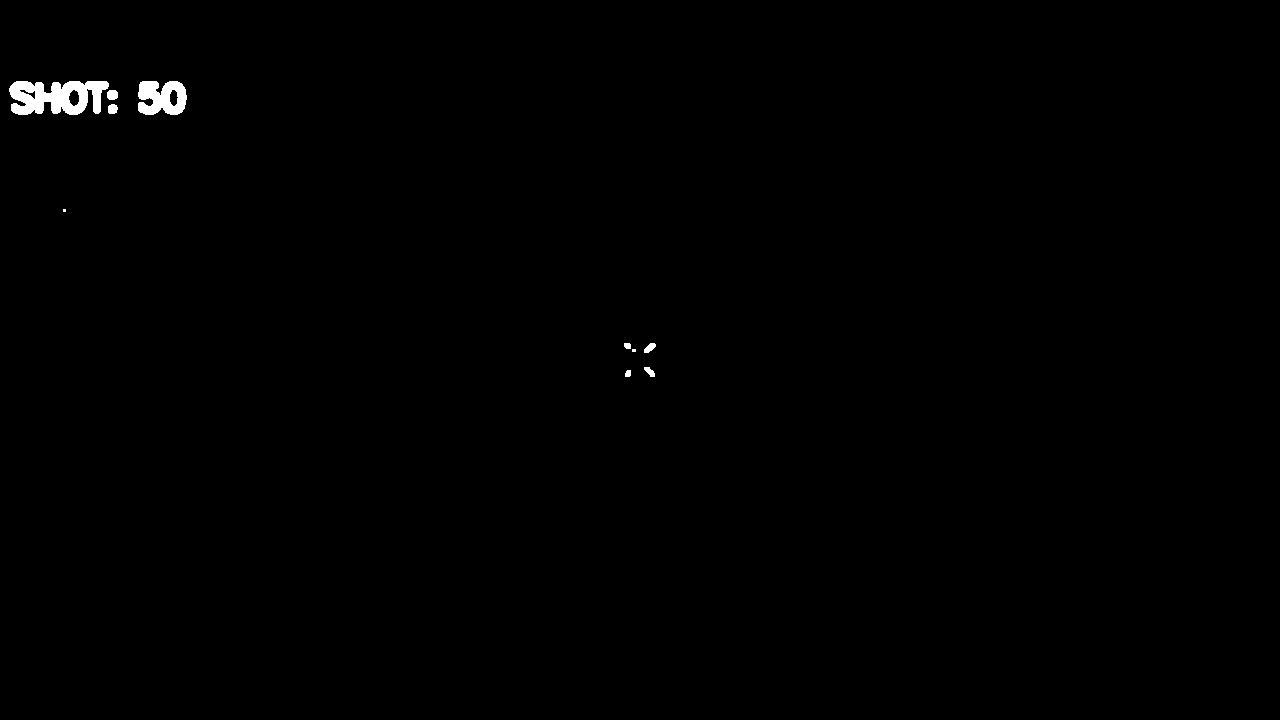

Orange Mask:


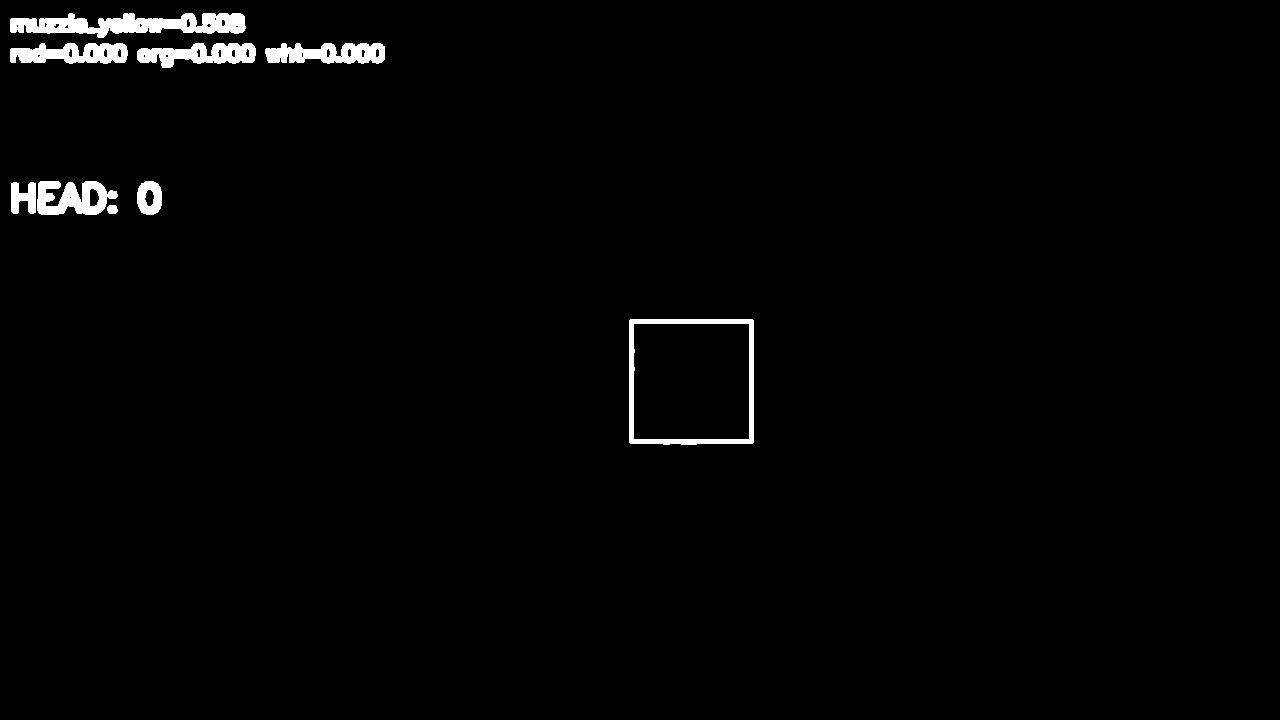

White Mask:


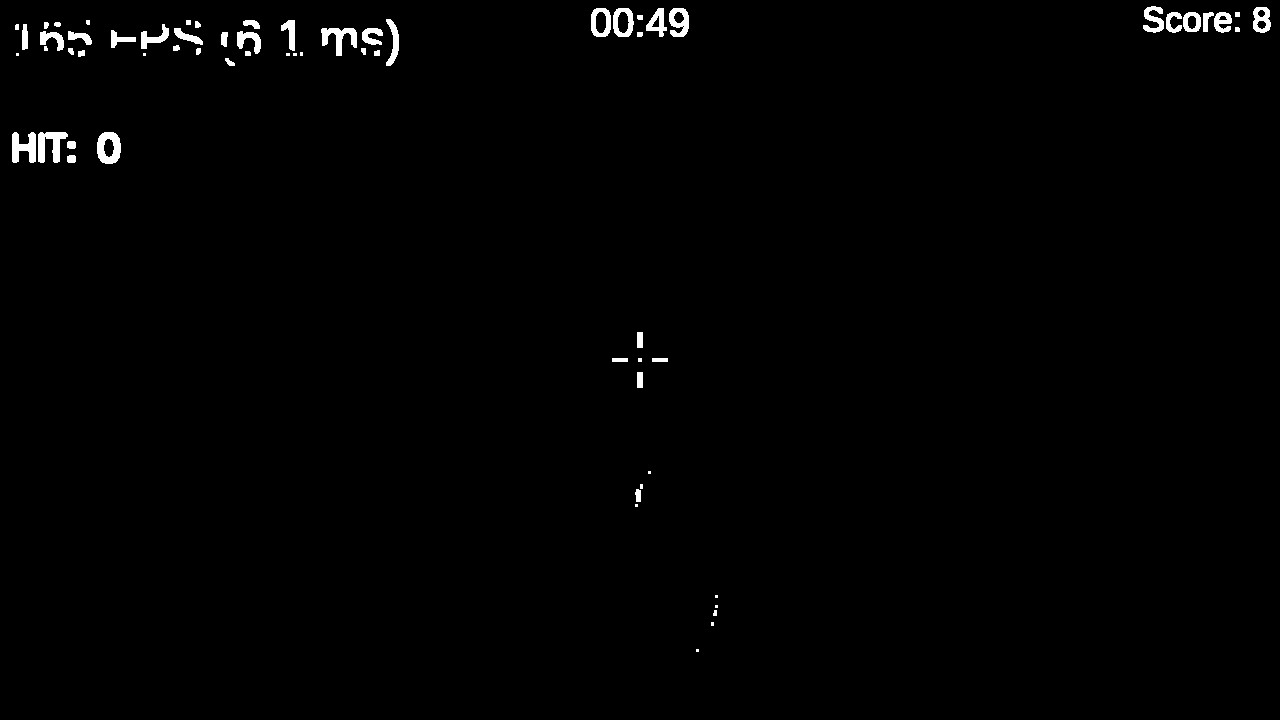

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow # cv2.imshow 대체용

# Define color ranges (copying from cell 1a425bfe)
lower_red1, upper_red1 = np.array([0, 100, 120]),  np.array([15, 255, 255])#킬 크로스헤어 빨강
lower_red2, upper_red2 = np.array([165, 100, 120]), np.array([180, 255, 255])#킬 크로스헤어 빨강
lower_orange, upper_orange = np.array([15, 100, 120]), np.array([35, 255, 255])#헤드샷 크로스헤어 주황
lower_white, upper_white = np.array([0, 0, 200]),   np.array([255, 40, 255])#일반 명중 크로스헤어 흰색


# Load a single frame image (replace with the actual path to your saved frame)
frame_path = "/content/frames/frame_0380.jpg" # Example: replace with a frame saved from the previous cell
frame = cv2.imread(frame_path)

if frame is not None:
    print(f"Loaded frame from: {frame_path}")

    # Convert frame to HSV
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Generate the masks
    red_mask_full = cv2.inRange(hsv_frame, lower_red1, upper_red1) + \
                    cv2.inRange(hsv_frame, lower_red2, upper_red2)
    orange_mask_full = cv2.inRange(hsv_frame, lower_orange, upper_orange)
    white_mask_full  = cv2.inRange(hsv_frame, lower_white, upper_white)


    # Apply morphological operations (using dilate as requested)
    kernel = np.ones((3,3), np.uint8)
    red_mask_full = cv2.dilate(red_mask_full, kernel, iterations=1)
    orange_mask_full = cv2.dilate(orange_mask_full, kernel, iterations=1)
    white_mask_full  = cv2.dilate(white_mask_full, kernel, iterations=1)


    # Display the original frame and the masks
    print("Original Frame:")
    cv2_imshow(frame)
    print("Red Mask:")
    cv2_imshow(red_mask_full)
    print("Orange Mask:")
    cv2_imshow(orange_mask_full)
    print("White Mask:")
    cv2_imshow(white_mask_full)


else:
    print(f"Error: Could not load frame from {frame_path}. Please check the path.")